# Creating an ML regression model that predicts Rent in the city of Berlin.
## Parameters selected are 
### The apartment is newly constructed, has a balcony, a Kitchen, has cellar, the living Space size, has lift, the number of  Rooms, has garden, a type of floor, and location in Berlin.

## First step is to import all the libraries.
### That include pandas, numpy, matplotlib with pyplot, 
### Scikit-learn libraries:
### Data processing: StandardScaler and train_test_split, 
### Model and hyperparamter tuning:LinearRegression GridSearchCV, and Pipeline
### Result analysis :mean_absolute_error, mean_squared_error, and r2_score

In [9]:
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import cupy as cp
from xgboost import DMatrix, XGBRegressor
from xgboost import XGBRegressor

### Importing data from csv file https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany

In [10]:
df1 = pd.read_csv('immo_data.csv')
df1.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,...,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,...,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,...,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,...,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,...,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

## Data preprocessing.
#### Selecting all the data we need 

In [12]:
#keeping only locations which are in Berlin
df1=df1[df1['regio1']=='Berlin']

In [13]:
# Droping all the columns from our data set which
df_berlin=df1[['newlyConst', 'balcony', 'hasKitchen', 'cellar', 'livingSpace', 'lift', 'floor','noRooms', 'garden', 'typeOfFlat', 'regio3','totalRent']].copy()


In [14]:
df_berlin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10406 entries, 45 to 268829
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   newlyConst   10406 non-null  bool   
 1   balcony      10406 non-null  bool   
 2   hasKitchen   10406 non-null  bool   
 3   cellar       10406 non-null  bool   
 4   livingSpace  10406 non-null  float64
 5   lift         10406 non-null  bool   
 6   floor        9306 non-null   float64
 7   noRooms      10406 non-null  float64
 8   garden       10406 non-null  bool   
 9   typeOfFlat   9602 non-null   object 
 10  regio3       10406 non-null  object 
 11  totalRent    9744 non-null   float64
dtypes: bool(6), float64(4), object(2)
memory usage: 630.1+ KB


### checking values of object columns
### we need to see if the values in type of floor and regio3(location) columns are correct.

In [15]:
non_numeric_columns = df_berlin[['regio3','typeOfFlat']].columns

for column in non_numeric_columns:
    unique_values = df_berlin[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in regio3: ['Staaken_Spandau' 'Weißensee_Weißensee' 'Mitte_Mitte'
 'Kreuzberg_Kreuzberg' 'Tiergarten_Tiergarten' 'Grünau_Köpenick'
 'Marzahn_Marzahn' 'Köpenick_Köpenick'
 'Neu_Hohenschönhausen_Hohenschönhausen' 'Hellersdorf_Hellersdorf'
 'Prenzlauer_Berg_Prenzlauer_Berg' 'Französisch_Buchholz_Pankow'
 'Charlottenburg_Charlottenburg' 'Mariendorf_Tempelhof'
 'Neukölln_Neukölln' 'Schmargendorf_Wilmersdorf' 'Wedding_Wedding'
 'Siemensstadt_Spandau' 'Britz_Neukölln' 'Buch_Pankow'
 'Friedrichshain_Friedrichshain' 'Karow_Weißensee'
 'Wilmersdorf_Wilmersdorf' 'Reinickendorf_Reinickendorf'
 'Schmöckwitz_Köpenick' 'Wittenau_Reinickendorf' 'Spandau_Spandau'
 'Adlershof_Treptow' 'Friedenau_Schöneberg'
 'Alt_Hohenschönhausen_Hohenschönhausen' 'Schöneberg_Schöneberg'
 'Friedrichsfelde_Lichtenberg' 'Karlshorst_Lichtenberg'
 'Oberschöneweide_Köpenick' 'Pankow_Pankow' 'Johannisthal_Treptow'
 'Lichterfelde_Steglitz' 'Konradshöhe_Reinickendorf'
 'Heinersdorf_Weißensee' 'Waidmannslust_Reinic

### The issue with some of the names with nue and alt was tackled by changing nue to nue- and alt to alt-.
### renzlauer, Berg  was written as 'Prenzlauer, Berg, Prenzlauer, Berg' which did not make sense so it was changed to Prenzlauer, Berg. As well Französisch, Buchholz, Pankow wa changed to Buchholz, Pankow.
### underscores where changed to space because we are planning to pull these same names to our UI. 

In [16]:

df_berlin['typeOfFlat'] = df_berlin['typeOfFlat'].str.replace('_', ' ')
df_berlin['regio3'] = df_berlin['regio3'].str.replace('_', ', ')
df_berlin['regio3'] = df_berlin['regio3'].str.replace('Neu, ', 'Neu-')
df_berlin['regio3'] = df_berlin['regio3'].str.replace('Alt, ', 'Alt-')
df_berlin['regio3'] = df_berlin['regio3'].str.replace('Prenzlauer, Berg, Prenzlauer, Berg', 'Prenzlauer, Berg')
df_berlin['regio3'] = df_berlin['regio3'].str.replace('Französisch, Buchholz, Pankow', 'Buchholz, Pankow')

### Some values had floor numbers but no information about the type of flat, so type of flat was assumed by the basis of floor number.

In [17]:
for index, row in df_berlin.iterrows():
    if row['typeOfFlat'] == 'other' and row['floor'] > 0:
        df_berlin.at[index, 'typeOfFlat'] = 'apartment'
    elif row['typeOfFlat'] == 'other' and row['floor'] == 0:
        df_berlin.at[index, 'typeOfFlat'] = 'ground floor'
    elif row['typeOfFlat'] == 'other' and row['floor'] < 0:
        df_berlin.at[index, 'typeOfFlat'] = 'half basement'
        
for index, row in df_berlin.iterrows():
    if pd.isna(row['typeOfFlat']) and row['floor'] > 0:
        df_berlin.at[index, 'typeOfFlat'] = 'apartment'
    elif pd.isna(row['typeOfFlat']) and row['floor'] == 0:
        df_berlin.at[index, 'typeOfFlat'] = 'ground floor'
    elif pd.isna(row['typeOfFlat'])  and row['floor'] < 0:
        df_berlin.at[index, 'typeOfFlat'] = 'half basement'    
df_berlin.drop(columns=['floor'], inplace=True)  

In [18]:
df_berlin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10406 entries, 45 to 268829
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   newlyConst   10406 non-null  bool   
 1   balcony      10406 non-null  bool   
 2   hasKitchen   10406 non-null  bool   
 3   cellar       10406 non-null  bool   
 4   livingSpace  10406 non-null  float64
 5   lift         10406 non-null  bool   
 6   noRooms      10406 non-null  float64
 7   garden       10406 non-null  bool   
 8   typeOfFlat   10270 non-null  object 
 9   regio3       10406 non-null  object 
 10  totalRent    9744 non-null   float64
dtypes: bool(6), float64(3), object(2)
memory usage: 806.8+ KB


### Null values will be removed later because in data processing some of them will be removed.
### Checking the distribution and outliers of the columns

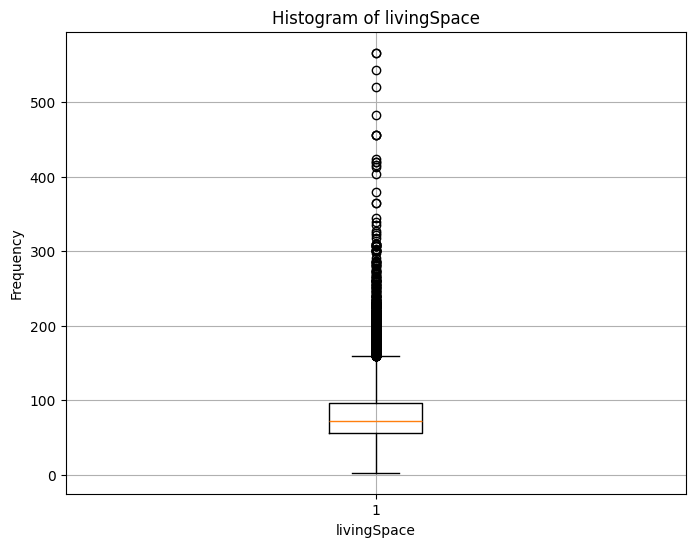

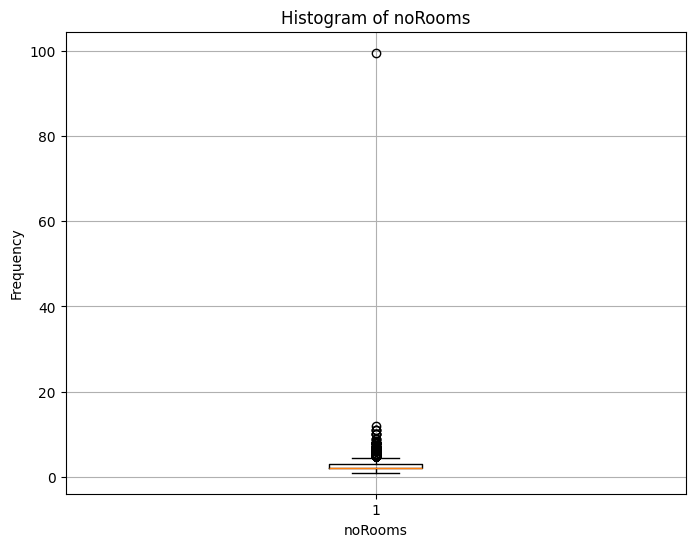

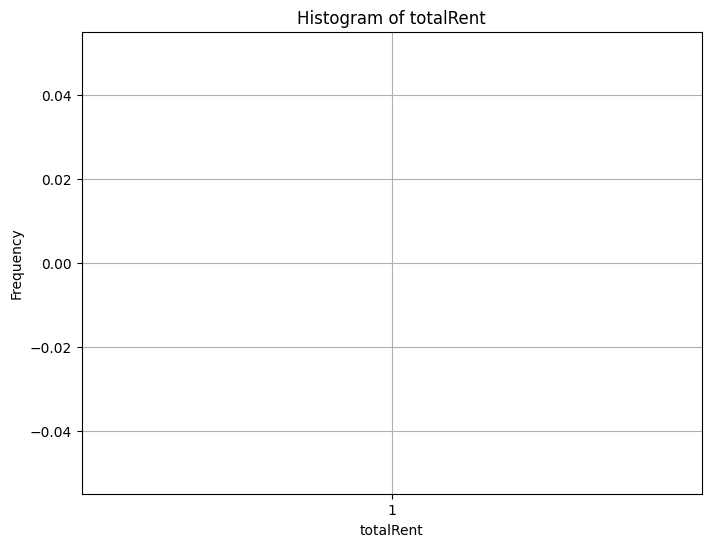

In [19]:
numerical_columns = df_berlin.select_dtypes(include=['int64', 'float64']).columns

for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(df_berlin[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

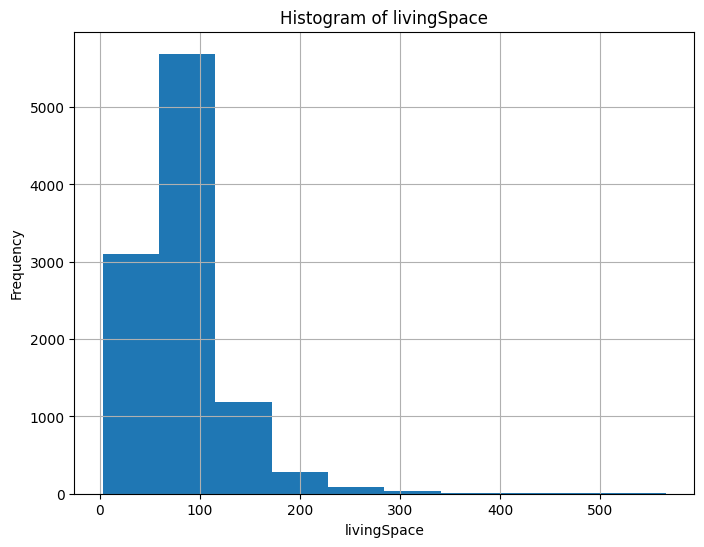

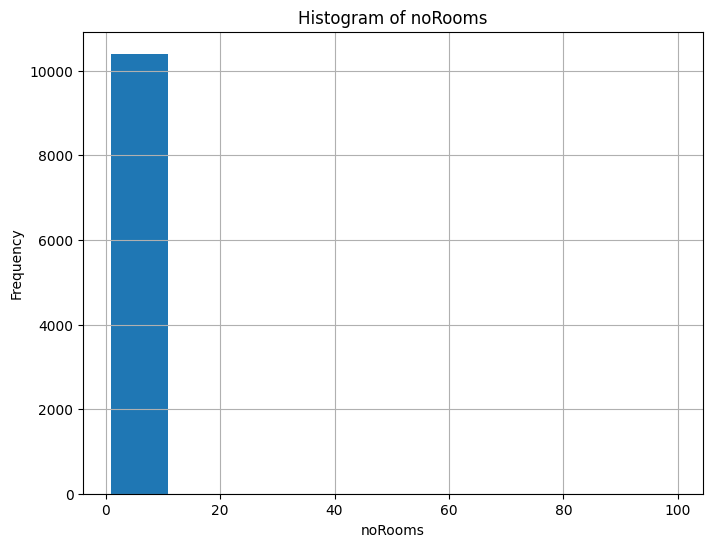

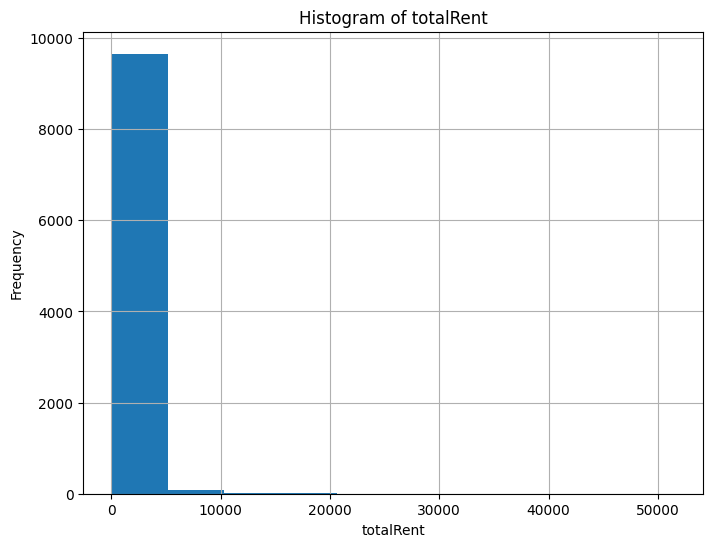

In [20]:
numerical_columns = df_berlin.select_dtypes(include=['int64', 'float64']).columns

for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df_berlin[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Plenty of outliers are there but there is an important feature of rent per sq meter which is not present in pdf. so a new column was created and made sure that all the rows had at least rent per sq meter of more than 10 euros per sq meter because in Berlin according to a news article average rent per sq meter is 14 to 16.

In [21]:
df_berlin['rent_per_sq']=df_berlin['totalRent']/df_berlin['livingSpace']

In [22]:
df_berlin=df_berlin[df_berlin['rent_per_sq']>=10]

## Removing all the outliers. 
###  Using the Inter Quantile Range(IQR)

In [23]:
Q1 = df_berlin[['livingSpace', 'totalRent','noRooms','rent_per_sq']].quantile(0.25)
Q3 = df_berlin[['livingSpace', 'totalRent','noRooms','rent_per_sq']].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
print(Q3)
print(Q1)
data_IQR = df_berlin[~((df_berlin[['livingSpace', 'totalRent','noRooms','rent_per_sq']] < (Q1 - 1.5 * IQR)) | (df_berlin[['livingSpace', 'totalRent','noRooms','rent_per_sq']] > (Q3 + 1.5 * IQR))).any(axis=1)]
data_IQR.describe()

livingSpace     41.710000
totalRent      893.500000
noRooms          1.000000
rent_per_sq      6.954196
dtype: float64
livingSpace      96.710000
totalRent      1708.180000
noRooms           3.000000
rent_per_sq      20.201618
Name: 0.75, dtype: float64
livingSpace     55.000000
totalRent      814.680000
noRooms          2.000000
rent_per_sq     13.247423
Name: 0.25, dtype: float64


,livingSpace,noRooms,totalRent,rent_per_sq
count,8357.000000,8357.000000,8357.000000,8357.000000
mean,73.655224,2.375853,1216.366629,16.644214
std,27.151463,0.857470,544.908394,4.443349
min,17.000000,1.000000,226.750000,10.000000
25%,55.000000,2.000000,798.000000,13.033175
50%,70.000000,2.000000,1095.000000,15.873470
75%,90.000000,3.000000,1533.720000,19.685803
max,159.250000,4.500000,3045.000000,30.615385


In [24]:
data_IQR

,newlyConst,balcony,hasKitchen,cellar,livingSpace,lift,noRooms,garden,typeOfFlat,regio3,totalRent,rent_per_sq
45,False,True,True,False,77.00,True,3.0,False,ground floor,"Staaken, Spandau",1140.00,14.805195
61,False,False,False,False,62.63,False,2.0,False,ground floor,"Weißensee, Weißensee",955.00,15.248284
77,True,True,True,True,46.40,True,2.0,False,apartment,"Mitte, Mitte",1300.00,28.017241
86,False,True,True,True,67.00,True,2.5,False,apartment,"Kreuzberg, Kreuzberg",1428.78,21.325075
87,True,True,True,True,73.54,True,2.0,False,ground floor,"Tiergarten, Tiergarten",1559.05,21.200027
...,...,...,...,...,...,...,...,...,...,...,...,...
268666,False,True,True,True,135.84,False,4.0,False,roof storey,"Friedrichshain, Friedrichshain",2513.44,18.502945
268709,False,True,True,True,85.00,True,3.0,True,apartment,"Schöneberg, Schöneberg",1250.00,14.705882
268716,False,False,False,True,57.00,False,1.0,False,roof storey,"Friedrichshagen, Köpenick",630.00,11.052632
268733,False,False,True,False,59.82,False,2.0,False,apartment,"Spandau, Spandau",850.00,14.209295


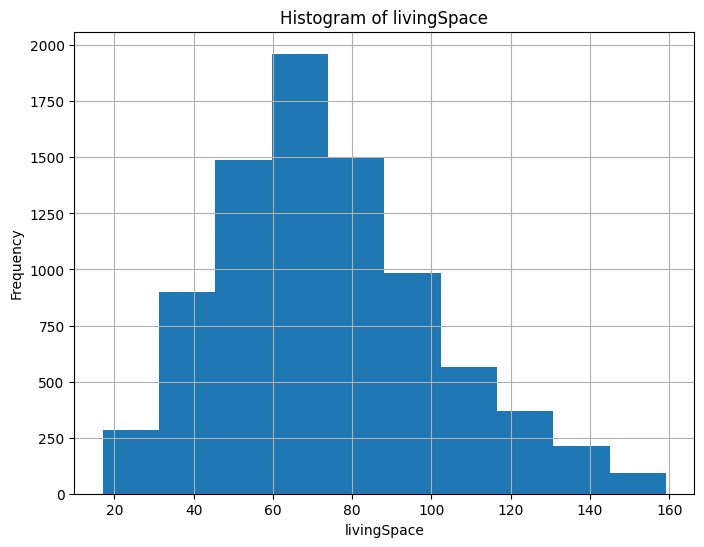

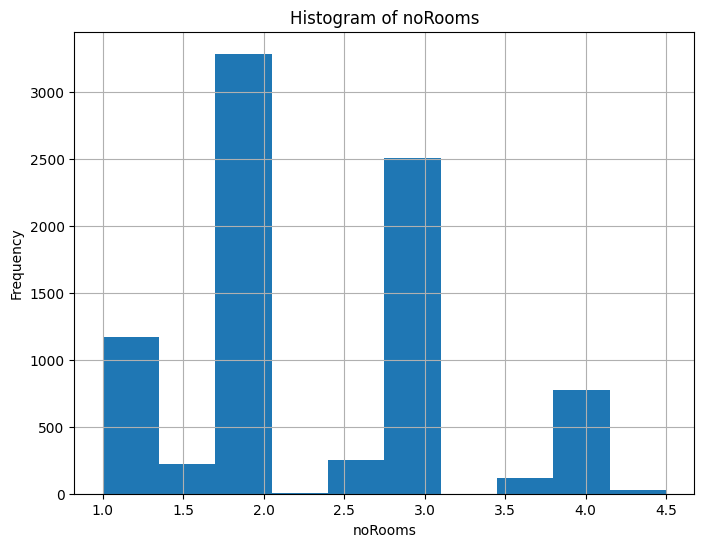

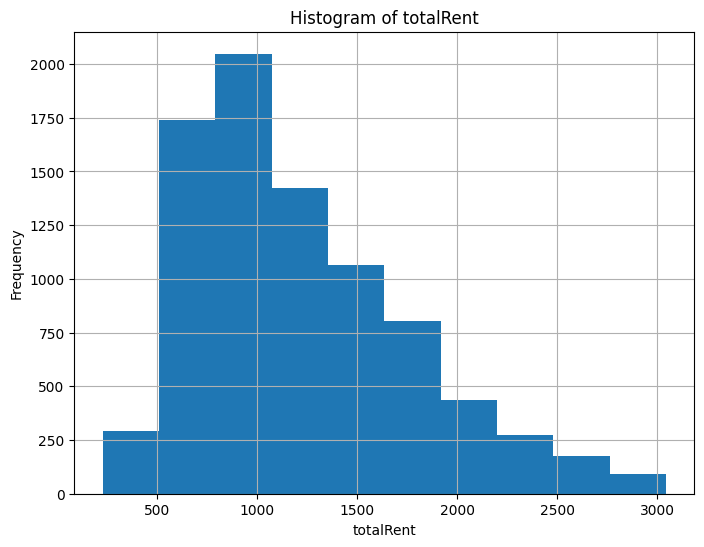

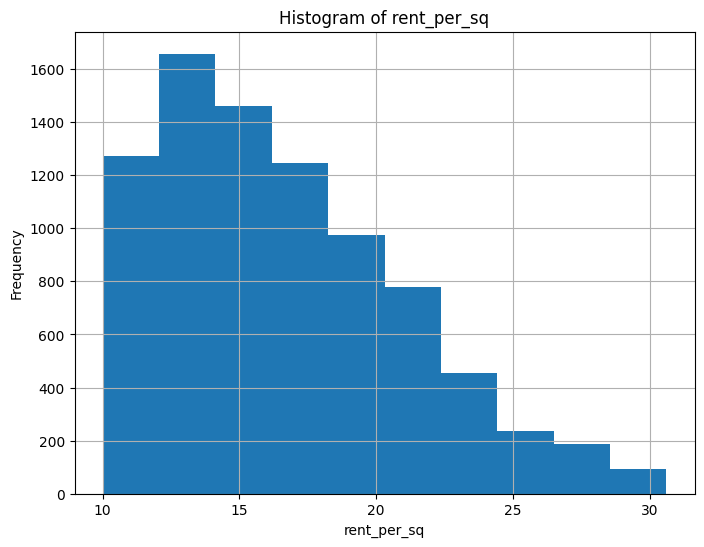

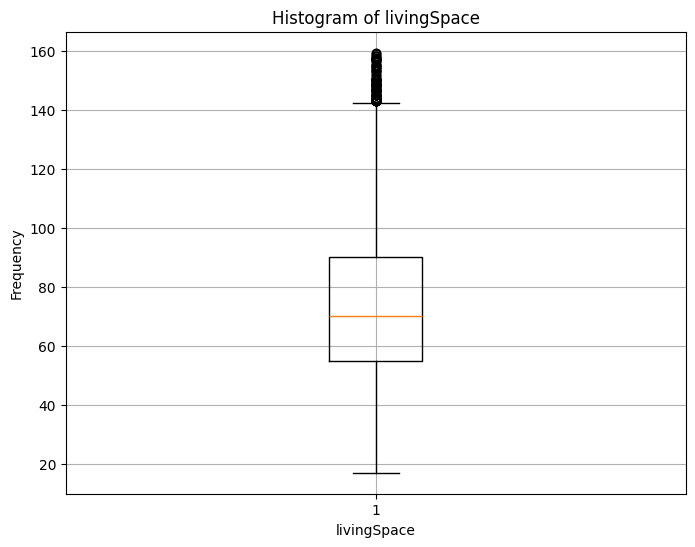

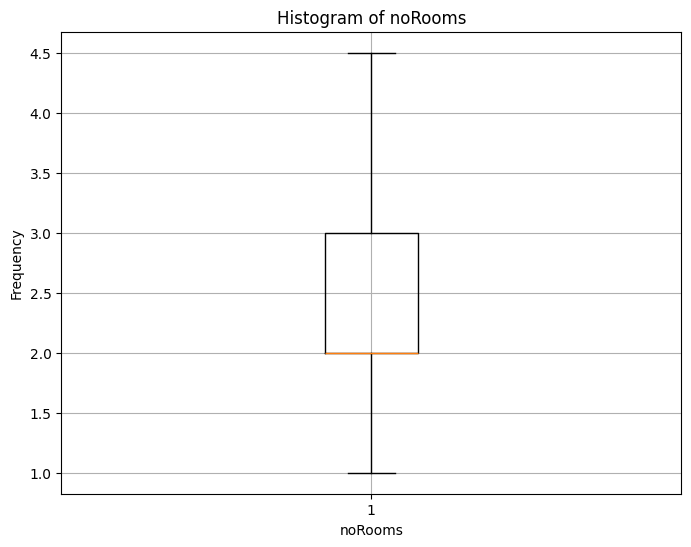

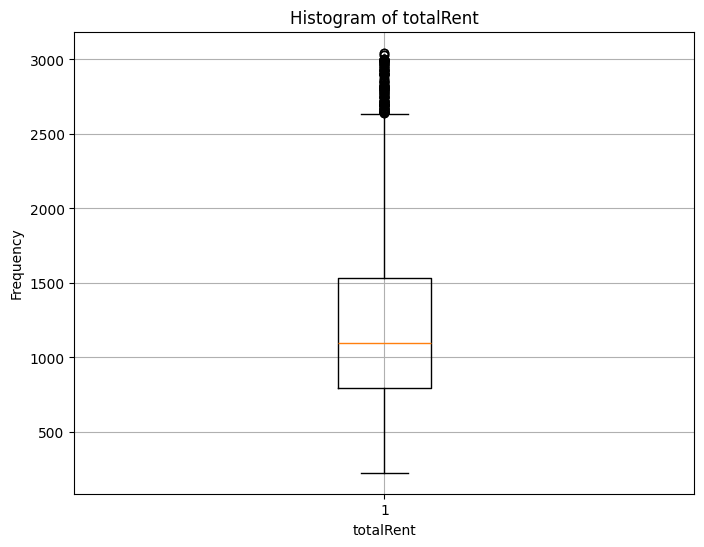

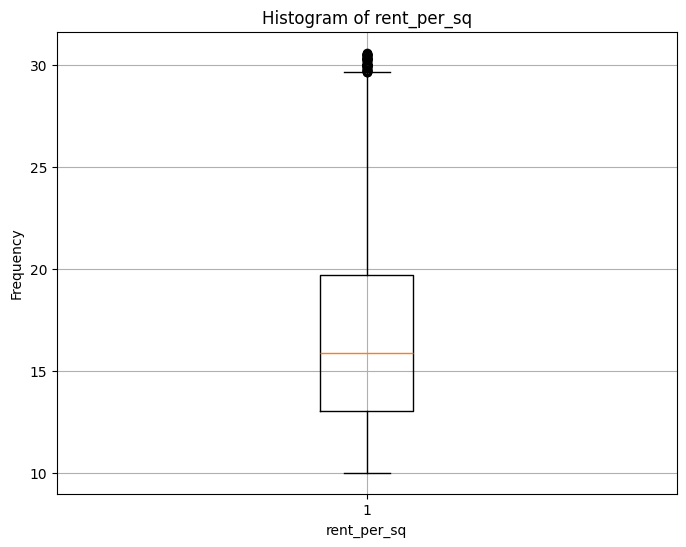

In [25]:
#Checking distribution and outliers again
numerical_columns = data_IQR.select_dtypes(include=['int64', 'float64']).columns

for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(data_IQR[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    


for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(data_IQR[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Distribution seems closer to normal and outliers are also in smaller quantity.
# Changing boolean data to 1 and 0

In [26]:
data_IQR['newlyConst'] = data_IQR['newlyConst'].astype(int)
data_IQR['balcony'] = data_IQR['balcony'].astype(int)
data_IQR['hasKitchen'] = data_IQR['hasKitchen'].astype(int)
data_IQR['cellar'] = data_IQR['cellar'].astype(int)
data_IQR['lift'] = data_IQR['lift'].astype(int)
data_IQR['garden'] = data_IQR['garden'].astype(int)


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_10652\3665486606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_IQR['newlyConst'] = data_IQR['newlyConst'].astype(int)
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_10652\3665486606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_IQR['balcony'] = data_IQR['balcony'].astype(int)
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_10652\3665486606.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [27]:
data_IQR.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8357 entries, 45 to 268829
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   newlyConst   8357 non-null   int32  
 1   balcony      8357 non-null   int32  
 2   hasKitchen   8357 non-null   int32  
 3   cellar       8357 non-null   int32  
 4   livingSpace  8357 non-null   float64
 5   lift         8357 non-null   int32  
 6   noRooms      8357 non-null   float64
 7   garden       8357 non-null   int32  
 8   typeOfFlat   8282 non-null   object 
 9   regio3       8357 non-null   object 
 10  totalRent    8357 non-null   float64
 11  rent_per_sq  8357 non-null   float64
dtypes: float64(4), int32(6), object(2)
memory usage: 652.9+ KB


### Some of the locations are in extremely low numbers, so for all the locations that are less than 10 in number, we join them and call them in other locations.

In [28]:
regio3_stat_less_than_10=data_IQR['regio3'].value_counts()[data_IQR['regio3'].value_counts() <=10]

In [29]:
regio3_stat_less_than_10

regio3
Rahnsdorf, Köpenick             10
Plänterwald, Treptow            10
Schmöckwitz, Köpenick           10
Müggelheim, Köpenick             7
Konradshöhe, Reinickendorf       4
Lübars, Reinickendorf            3
Blankenburg, Weißensee           3
Gatow, Spandau                   1
Falkenberg, Hohenschönhausen     1
Rummelsburg, Lichtenberg         1
Name: count, dtype: int64

In [30]:
for index, row in data_IQR.iterrows():
    if row['regio3'] in regio3_stat_less_than_10:
        data_IQR.at[index, 'regio3'] = 'other'
        

## One hot encoding for regio3 and type of flat column.

In [31]:
dummies1=pd.get_dummies(data_IQR.typeOfFlat)

In [32]:
dummies1

,apartment,ground floor,half basement,loft,maisonette,other,penthouse,raised ground floor,roof storey,terraced flat
45,False,True,False,False,False,False,False,False,False,False
61,False,True,False,False,False,False,False,False,False,False
77,True,False,False,False,False,False,False,False,False,False
86,True,False,False,False,False,False,False,False,False,False
87,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
268666,False,False,False,False,False,False,False,False,True,False
268709,True,False,False,False,False,False,False,False,False,False
268716,False,False,False,False,False,False,False,False,True,False
268733,True,False,False,False,False,False,False,False,False,False


In [33]:
# half basement si droped to prevent Multicollinearity.
df_berlin_flat_type=pd.concat([data_IQR,dummies1.drop('half basement',axis='columns')],axis='columns')

In [34]:
df_berlin_flat_type

,newlyConst,balcony,hasKitchen,cellar,livingSpace,lift,noRooms,garden,typeOfFlat,regio3,...,rent_per_sq,apartment,ground floor,loft,maisonette,other,penthouse,raised ground floor,roof storey,terraced flat
45,0,1,1,0,77.00,1,3.0,0,ground floor,"Staaken, Spandau",...,14.805195,False,True,False,False,False,False,False,False,False
61,0,0,0,0,62.63,0,2.0,0,ground floor,"Weißensee, Weißensee",...,15.248284,False,True,False,False,False,False,False,False,False
77,1,1,1,1,46.40,1,2.0,0,apartment,"Mitte, Mitte",...,28.017241,True,False,False,False,False,False,False,False,False
86,0,1,1,1,67.00,1,2.5,0,apartment,"Kreuzberg, Kreuzberg",...,21.325075,True,False,False,False,False,False,False,False,False
87,1,1,1,1,73.54,1,2.0,0,ground floor,"Tiergarten, Tiergarten",...,21.200027,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268666,0,1,1,1,135.84,0,4.0,0,roof storey,"Friedrichshain, Friedrichshain",...,18.502945,False,False,False,False,False,False,False,True,False
268709,0,1,1,1,85.00,1,3.0,1,apartment,"Schöneberg, Schöneberg",...,14.705882,True,False,False,False,False,False,False,False,False
268716,0,0,0,1,57.00,0,1.0,0,roof storey,"Friedrichshagen, Köpenick",...,11.052632,False,False,False,False,False,False,False,True,False
268733,0,0,1,0,59.82,0,2.0,0,apartment,"Spandau, Spandau",...,14.209295,True,False,False,False,False,False,False,False,False


In [35]:
dummies2=pd.get_dummies(data_IQR.regio3)

In [36]:
# half basement si droped to prevent Multicollinearity.
df_berlin_dummies=pd.concat([df_berlin_flat_type,dummies2.drop('Bohnsdorf, Treptow',axis='columns')],axis='columns')

In [37]:
df_berlin_dummies

,newlyConst,balcony,hasKitchen,cellar,livingSpace,lift,noRooms,garden,typeOfFlat,regio3,...,"Tiergarten, Tiergarten","Treptow, Treptow","Waidmannslust, Reinickendorf","Wannsee, Zehlendorf","Wedding, Wedding","Weißensee, Weißensee","Wilmersdorf, Wilmersdorf","Wittenau, Reinickendorf","Zehlendorf, Zehlendorf",other
45,0,1,1,0,77.00,1,3.0,0,ground floor,"Staaken, Spandau",...,False,False,False,False,False,False,False,False,False,False
61,0,0,0,0,62.63,0,2.0,0,ground floor,"Weißensee, Weißensee",...,False,False,False,False,False,True,False,False,False,False
77,1,1,1,1,46.40,1,2.0,0,apartment,"Mitte, Mitte",...,False,False,False,False,False,False,False,False,False,False
86,0,1,1,1,67.00,1,2.5,0,apartment,"Kreuzberg, Kreuzberg",...,False,False,False,False,False,False,False,False,False,False
87,1,1,1,1,73.54,1,2.0,0,ground floor,"Tiergarten, Tiergarten",...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268666,0,1,1,1,135.84,0,4.0,0,roof storey,"Friedrichshain, Friedrichshain",...,False,False,False,False,False,False,False,False,False,False
268709,0,1,1,1,85.00,1,3.0,1,apartment,"Schöneberg, Schöneberg",...,False,False,False,False,False,False,False,False,False,False
268716,0,0,0,1,57.00,0,1.0,0,roof storey,"Friedrichshagen, Köpenick",...,False,False,False,False,False,False,False,False,False,False
268733,0,0,1,0,59.82,0,2.0,0,apartment,"Spandau, Spandau",...,False,False,False,False,False,False,False,False,False,False


## Correlation between columns


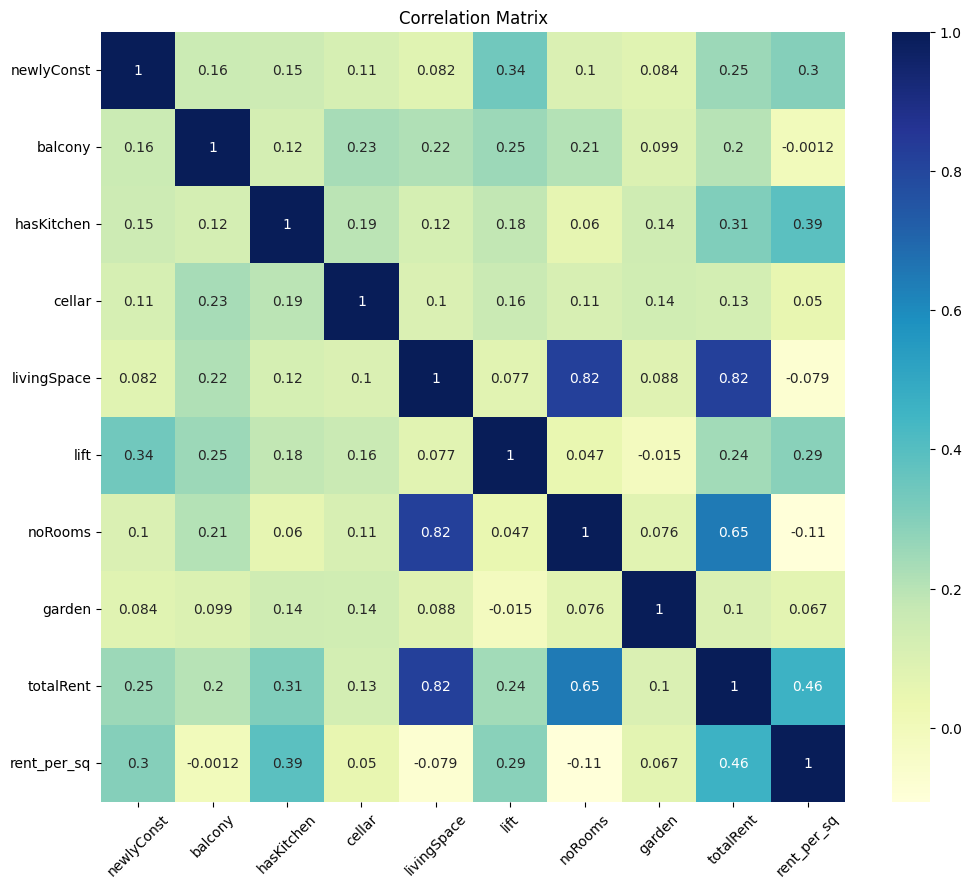

In [38]:


numeric_df = df_berlin_dummies.select_dtypes(include=['int32', 'float64'])

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='YlGnBu')
plt.xticks(rotation=45) 
plt.yticks(rotation=0) 
plt.title('Correlation Matrix')
plt.show()


## Dropping all the null values and converting booleans to 1 and 0
### Regio3, typeOfFlat, and rent_per_sq column were also droped 

In [39]:
df_berlin_dummies.dropna()
df_berlin_dummies.drop(columns=['regio3','typeOfFlat','rent_per_sq'], inplace=True)
df_berlin_dummies.loc[:]= df_berlin_dummies.astype(int)

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_10652\2282957761.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 0 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_berlin_dummies.loc[:]= df_berlin_dummies.astype(int)
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_10652\2282957761.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_berlin_dummies.loc[:]= df_berlin_dummies.astype(int)
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_10652\2282957761.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_

In [40]:
df_berlin_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8357 entries, 45 to 268829
Data columns (total 86 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   newlyConst                              8357 non-null   int32  
 1   balcony                                 8357 non-null   int32  
 2   hasKitchen                              8357 non-null   int32  
 3   cellar                                  8357 non-null   int32  
 4   livingSpace                             8357 non-null   float64
 5   lift                                    8357 non-null   int32  
 6   noRooms                                 8357 non-null   float64
 7   garden                                  8357 non-null   int32  
 8   totalRent                               8357 non-null   float64
 9   apartment                               8357 non-null   int32  
 10  ground floor                            8357 non-null   int32 

## Splitting the df to Fetaure and target set

In [41]:
X=df_berlin_dummies.drop(columns=['totalRent'])

In [42]:
X.columns

Index(['newlyConst', 'balcony', 'hasKitchen', 'cellar', 'livingSpace', 'lift',
       'noRooms', 'garden', 'apartment', 'ground floor', 'loft', 'maisonette',
       'other', 'penthouse', 'raised ground floor', 'roof storey',
       'terraced flat', 'Adlershof, Treptow',
       'Alt-Hohenschönhausen, Hohenschönhausen', 'Altglienicke, Treptow',
       'Baumschulenweg, Treptow', 'Biesdorf, Marzahn', 'Britz, Neukölln',
       'Buch, Pankow', 'Buchholz, Pankow', 'Buckow, Neukölln',
       'Charlottenburg, Charlottenburg', 'Dahlem, Zehlendorf',
       'Friedenau, Schöneberg', 'Friedrichsfelde, Lichtenberg',
       'Friedrichshagen, Köpenick', 'Friedrichshain, Friedrichshain',
       'Frohnau, Reinickendorf', 'Grunewald, Wilmersdorf', 'Grünau, Köpenick',
       'Haselhorst, Spandau', 'Heiligensee, Reinickendorf',
       'Heinersdorf, Weißensee', 'Hellersdorf, Hellersdorf',
       'Hermsdorf, Reinickendorf', 'Johannisthal, Treptow',
       'Karlshorst, Lichtenberg', 'Karow, Weißensee', 'Kaulsd

In [43]:
Y=df_berlin_dummies['totalRent']

In [44]:
# Changed X to X_Array because it is easier to manipulate and perform many functions on an array than df
X_array = X.values


#### We will perform a split of the data before every test run because later we will perform feature changes on Y
### First we are comparing LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, GradientBoostingRegressor, and KNeighborsRegressor
### After that we will hyper-tune RandomForestRegressor
### Last we compare the results with Xgboost regression 

In [45]:
X_train,X_test, y_train, y_test=  train_test_split(X_array, Y, test_size=0.2, random_state=42)
models = {
    'Linear Regression_o': LinearRegression(),
    'Ridge Regression_o': Ridge(),
    'Lasso Regression_o': Lasso(),
    'ElasticNet_o': ElasticNet(),
    'Random Forest_o': RandomForestRegressor(),
    'Gradient Boosting_o': GradientBoostingRegressor(),
    'knn_regressor_o' : KNeighborsRegressor(n_neighbors=5)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    score = model.score(X_test, y_test)
    print(f"{name}: MAE {mae}, Score: {score}")
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [ 120,135,140],
    'max_depth': [ 22,23],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestRegressor()
 

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_rf_model_o = grid_search.best_estimator_

predictions = best_rf_model_o.predict(X_test)

print ('score is', best_rf_model_o.score(X_test, y_test))
mae = mean_absolute_error(y_test, predictions)
score = best_rf_model_o.score(X_test, y_test)
print(f"{name}: MAE {mae}, Score: {score}")
# to run Xgboost on gpu 
X_train_cp = cp.array(X_train)
y_train_cp = cp.array(y_train)
X_test_cp = cp.array(X_test)

dtrain = DMatrix(X_train_cp, label=y_train_cp)


model_o = XGBRegressor(
    tree_method="hist",  
    device="cuda" 
       
)

model_o.fit(X_train, y_train)


y_pred = model_o.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


score = model_o.score(X_test, y_test)
print(f'XGBoost R^2 score: {score}')

Linear Regression_o: MAE 162.53128192168364, Score: 0.8533928035879851
Ridge Regression_o: MAE 162.45453167418404, Score: 0.8535074611898819
Lasso Regression_o: MAE 165.57487757878368, Score: 0.8489413049294308
ElasticNet_o: MAE 221.52246174465415, Score: 0.7517833208826081
Random Forest_o: MAE 146.99913600552205, Score: 0.8577744162924733
Gradient Boosting_o: MAE 159.17009294594203, Score: 0.8572022057279226
knn_regressor_o: MAE 185.73062200956937, Score: 0.8011414095120213
score is 0.8580074919943278
knn_regressor_o: MAE 147.99036806279992, Score: 0.8580074919943278
Mean Absolute Error: 145.07316326524654
XGBoost R^2 score: 0.8692983664664679


c:\Users\Abhishek\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### ElasticNet showed the worst results 
### XGBoost  was best and hyper-tuned RandomForestRegressor was second best 

In [47]:
# using the cube root of the target variable.
y_cbrt=np.cbrt(Y)


X_train,X_test, y_train, y_test=  train_test_split(X_array, y_cbrt, test_size=0.2, random_state=42)
y_train_cb=np.power(y_train, 3)
y_test_cb=np.power(y_test, 3)
models = {
    'Linear Regression_c': LinearRegression(),
    'Ridge Regression_c': Ridge(),
    'Lasso Regression_c': Lasso(),
    'ElasticNet_c': ElasticNet(),
    'Random Forest_c': RandomForestRegressor(),
    'Gradient Boosting_c': GradientBoostingRegressor(),
    'knn_regressor_c' : KNeighborsRegressor(n_neighbors=5)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    score = model.score(X_test, y_test)
    print(f"{name}: MAE {mae}, Score: {score}")
    y_pred_cube=np.power(y_pred, 3)
    maec = mean_absolute_error(y_test_cb, y_pred_cube)
    score = r2 = r2_score(y_test_cb, y_pred_cube)
    print(f"{name}: MAE for orginal {maec}, Score: {score}")
    

param_grid = {
    'n_estimators': [ 120,135,140],
    'max_depth': [ 22,23],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestRegressor()
 

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_rf_model_c = grid_search.best_estimator_

predictions = best_rf_model_c.predict(X_test)

print ('score is', best_rf_model_c.score(X_test, y_test))
y_pred_cube=np.power(predictions, 3)
maec = mean_absolute_error(y_test_cb, y_pred_cube)
score = r2 = r2_score(y_test_cb, y_pred_cube)
print('MAE for orginal', {maec}, 'Score:', {score})

# to run Xgboost on gpu 
X_train_cp = cp.array(X_train)
y_train_cp = cp.array(y_train)
X_test_cp = cp.array(X_test)

dtrain = DMatrix(X_train_cp, label=y_train_cp)

model_c = XGBRegressor(
    tree_method="hist",  
    device="cuda"      
)
model_c.fit(X_train, y_train)

y_pred = model_c.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

score = model_c.score(X_test, y_test)
print(f'XGBoost R^2 score: {score}')
y_pred_cube=np.power(y_pred, 3)
maec = mean_absolute_error(y_test_cb, y_pred_cube)
score = r2 = r2_score(y_test_cb, y_pred_cube)
print('MAE for orginal', {maec}, 'Score:', {score})


Linear Regression_c: MAE 0.45091391837373884, Score: 0.8642398835916867
Linear Regression_c: MAE for orginal 153.6032051756922, Score: 0.8600008812406007
Ridge Regression_c: MAE 0.45100750137575485, Score: 0.8643214507414594
Ridge Regression_c: MAE for orginal 153.61598955642185, Score: 0.8600012905693398
Lasso Regression_c: MAE 0.7321115416641422, Score: 0.6944537594939868
Lasso Regression_c: MAE for orginal 249.0854741686156, Score: 0.6805116588377962
ElasticNet_c: MAE 0.7303565340428642, Score: 0.6954132733632143
ElasticNet_c: MAE for orginal 248.6565504124655, Score: 0.6807282891955969
Random Forest_c: MAE 0.4299473760779178, Score: 0.8652368469571574
Random Forest_c: MAE for orginal 147.87390290533787, Score: 0.856404284650903
Gradient Boosting_c: MAE 0.46081904465030255, Score: 0.8634200534779972
Gradient Boosting_c: MAE for orginal 156.4966260024664, Score: 0.8572987355091137
knn_regressor_c: MAE 0.5338840510717904, Score: 0.8131351427769206
knn_regressor_c: MAE for orginal 184.

## taking cube root was better as it showed on almost all the models.
### ElasticNet showed the worst results 
### XGBoost  was best and hyper-tuned RandomForestRegressor was second best 

In [48]:
# using the log of the target variable.
y_cbrt=np.log(Y)


X_train,X_test, y_train, y_test=  train_test_split(X_array, y_cbrt, test_size=0.2, random_state=42)
y_train_cb=np.exp(y_train)
y_test_cb=np.exp(y_test)
models = {
    'Linear Regression_l': LinearRegression(),
    'Ridge Regression_l': Ridge(),
    'Lasso Regression_l': Lasso(),
    'ElasticNet_l': ElasticNet(),
    'Random Forest_l': RandomForestRegressor(),
    'Gradient Boosting_l': GradientBoostingRegressor(),
    'knn_regressor_l' : KNeighborsRegressor(n_neighbors=5)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    score = model.score(X_test, y_test)
    print(f"{name}: MAE {mae}, Score: {score}")
    y_pred_cube=np.exp(y_pred)
    maec = mean_absolute_error(y_test_cb, y_pred_cube)
    score = r2 = r2_score(y_test_cb, y_pred_cube)
    print(f"{name}: MAE for orginal {maec}, Score: {score}")
    

param_grid = {
    'n_estimators': [ 120,135,140],
    'max_depth': [ 22,23],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestRegressor()
 

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_rf_model_l = grid_search.best_estimator_

predictions = best_rf_model_l.predict(X_test)

print ('score is', best_rf_model_l.score(X_test, y_test))
y_pred_cube=np.exp(predictions)
maec = mean_absolute_error(y_test_cb, y_pred_cube)
score = r2 = r2_score(y_test_cb, y_pred_cube)
print('MAE for orginal', {maec}, 'Score:', {score})


# to run Xgboost on gpu 
X_train_cp = cp.array(X_train)
y_train_cp = cp.array(y_train)
X_test_cp = cp.array(X_test)

dtrain = DMatrix(X_train_cp, label=y_train_cp)

model_l = XGBRegressor(
    tree_method="hist",  
    device="cuda"        
)


model_l.fit(X_train, y_train)


y_pred = model_l.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


score = model_l.score(X_test, y_test)
print(f'XGBoost R^2 score: {score}')
y_pred_cube=np.exp(y_pred)
maec = mean_absolute_error(y_test_cb, y_pred_cube)
score = r2 = r2_score(y_test_cb, y_pred_cube)
print('MAE for orginal', {maec}, 'Score:', {score})


Linear Regression_l: MAE 0.13528869099244997, Score: 0.8517966353229095
Linear Regression_l: MAE for orginal 161.26209392807274, Score: 0.8412959435857703
Ridge Regression_l: MAE 0.13528461538063682, Score: 0.8518616435142972
Ridge Regression_l: MAE for orginal 161.22982291615122, Score: 0.841339453513345
Lasso Regression_l: MAE 0.21801258273088706, Score: 0.672045192439819
Lasso Regression_l: MAE for orginal 255.96785891811618, Score: 0.6571801396797612
ElasticNet_l: MAE 0.2152164954750588, Score: 0.6792093353794065
ElasticNet_l: MAE for orginal 254.3778570273192, Score: 0.6569679790818902
Random Forest_l: MAE 0.12385690413976068, Score: 0.8643866707644913
Random Forest_l: MAE for orginal 147.4385180067615, Score: 0.8562942308829121
Gradient Boosting_l: MAE 0.1336876489105602, Score: 0.8595837340568314
Gradient Boosting_l: MAE for orginal 156.72645304806042, Score: 0.8546766694823543
knn_regressor_l: MAE 0.15342791818569285, Score: 0.8120148589996438
knn_regressor_l: MAE for orginal 1

### It was clear that Xgboost with one log of target data performed best now it was time to do hypertuning  
### Hypertuning xgboost took too many resources so it is an aspect of the future.

In [ ]:
y_cbrt=np.log(Y)
X_train,X_test, y_train, y_test=  train_test_split(X_array, y_cbrt, test_size=0.2, random_state=42)

model1 = XGBRegressor(tree_method="hist", device="cuda")

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}


grid_search = GridSearchCV(estimator=model1, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

grid_result = grid_search.fit(X_train, y_train)

print("Best parameters:", grid_result.best_params_)

model = grid_result.best_estimator_
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

score = model.score(X_test, y_test)
print(f'XGBoost R^2 score: {score}')
y_pred_cube=np.exp(y_pred)
maec = mean_absolute_error(y_test_cb, y_pred_cube)
score = r2 = r2_score(y_test_cb, y_pred_cube)
print('MAE for orginal', {maec}, 'Score:', {score})

NameError: name 'Y' is not defined

## Now it was time to use the model and perform predictions.

In [49]:
models = {
    'best_rf_model_o': best_rf_model_o,
    'model_o': model_o,
    'best_rf_model_l': best_rf_model_l,
    'model_l': model_l,
    'best_rf_model_c': best_rf_model_c,
    'model_c': model_c
}

def predict_price(newlyConst, balcony, hasKitchen, cellar, livingSpace, lift, noRooms, garden, floor, location):
    loc_index = np.where(X.columns == location)[0]
    floor_index = np.where(X.columns == floor)[0]
    
    x = np.zeros(len(X.columns))
    x[0] = newlyConst
    x[1] = balcony
    x[2] = hasKitchen
    x[3] = cellar
    x[4] = livingSpace
    x[5] = lift
    x[6] = noRooms
    x[7] = garden
    
    if len(floor_index) >= 0:
        x[floor_index[0]] = 1
    if len(loc_index) >= 0:
        x[loc_index[0]] = 1
    
    for model_name, model in models.items():
        if model_name == 'best_rf_model_o' or model_name == 'model_o':
      
            print(f"{model_name} predicted {model.predict([x])[0]}")
        elif model_name == 'best_rf_model_l' or model_name == 'model_l':
        
            print(f"{model_name} predicted {np.exp(model.predict([x])[0])}")
        else:
         
            print(f"{model_name} predicted {np.power(model.predict([x])[0], 3)}")

# Call the function
predict_price(0, 0, 0, 0, 57, 0, 1, 0, 'raised ground floor', 'Mitte, Mitte')

best_rf_model_o predicted 1028.5386222516481
model_o predicted 1311.64453125
best_rf_model_l predicted 1006.5361314933855
model_l predicted 1072.0579833984375
best_rf_model_c predicted 1046.42324008668
model_c predicted 1123.0026443296683


In [50]:
predict_price(0, 0, 1, 0, 47, 0, 2, 0, 'apartment', 'Mitte, Mitte')

best_rf_model_o predicted 1157.0142857142857
model_o predicted 1175.9107666015625
best_rf_model_l predicted 1151.8690523655123
model_l predicted 1129.13671875
best_rf_model_c predicted 1163.1128364928168
model_c predicted 1140.1543981000013


# Model with XGBRegressor with Log of Target data showed the best results so we will take it forward and get a pickle file so that we can run it on our server. We will also import a Jason file for our columns that we would be able to call in our server.

In [ ]:
import pickle
import json 

In [ ]:
with open ('berlin_price_model.pickle','wb') as f:
    pickle.dump(model_l,f)

In [ ]:
columns={'data_columns':[col.lower()for col in X.columns]}
with open ("columns.json",'w') as f:
    f.write(json.dumps(columns))

In [ ]:
columns

{'data_columns': ['newlyconst',
  'balcony',
  'haskitchen',
  'cellar',
  'livingspace',
  'lift',
  'norooms',
  'garden',
  'apartment',
  'ground floor',
  'loft',
  'maisonette',
  'other',
  'penthouse',
  'raised ground floor',
  'roof storey',
  'terraced flat',
  'adlershof, treptow',
  'alt-hohenschönhausen, hohenschönhausen',
  'altglienicke, treptow',
  'baumschulenweg, treptow',
  'biesdorf, marzahn',
  'britz, neukölln',
  'buch, pankow',
  'buchholz, pankow',
  'buckow, neukölln',
  'charlottenburg, charlottenburg',
  'dahlem, zehlendorf',
  'friedenau, schöneberg',
  'friedrichsfelde, lichtenberg',
  'friedrichshagen, köpenick',
  'friedrichshain, friedrichshain',
  'frohnau, reinickendorf',
  'grunewald, wilmersdorf',
  'grünau, köpenick',
  'haselhorst, spandau',
  'heiligensee, reinickendorf',
  'heinersdorf, weißensee',
  'hellersdorf, hellersdorf',
  'hermsdorf, reinickendorf',
  'johannisthal, treptow',
  'karlshorst, lichtenberg',
  'karow, weißensee',
  'kaulsdo